In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import random

import dask.dataframe as dd

sys.path.append("../")
from src.utils import *
from src.LSN_roi import *
from src.simul import *

import matplotlib.pyplot as plt

/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
summary_results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/summary/"
results_configs = {
                    "SFCN": "SFCN_model_single_visit_train_two_visit_subset_test_two_visit_subset.csv",
                    "Baseline_single_visit (full-ses2)": "baseline_model_single_visit_train_full_ses2_test_two_visit_subset.csv",
                    "Baseline_single_visit (two-visit-subset)": "baseline_model_single_visit_train_two_visit_subset_test_two_visit_subset.csv",
                    "Baseline_two_visits": "baseline_model_two_visits_train_two_visit_subset_test_two_visit_subset.csv",
                    "LSN": "LSN_model_two_visit_train_two_visit_subset_test_two_visit_subset.csv"
                }

# n_test subjects: SFCN (3 error_type): 8799/3,
# Baseline_single_visit_large (3 error_type): 9603/3, 
# Baseline_single_visit_small(3 error_type): 3171/3, 
# Baseline_two_visits (3 error_type, 2 models, 2 data_aug): 11496/(3*2*2),
# LSN (3 error_type, 2 data_aug): 5748/(3*2)


In [3]:
perf_df = pd.DataFrame()
for config, f in results_configs.items():
    df = pd.read_csv(f"{summary_results_dir}{f}")
    print(f"config: {config}, df shape: {df.shape}")
    df["config"] = config
    perf_df = perf_df.append(df)

perf_df.loc[perf_df["data_aug"].isna(),"data_aug"] = False
perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

print(perf_df["visit_order"].unique())

perf_df.head()

config: SFCN, df shape: (8799, 11)
config: Baseline_single_visit (full-ses2), df shape: (26805, 11)
config: Baseline_single_visit (two-visit-subset), df shape: (8919, 11)
config: Baseline_two_visits, df shape: (11496, 12)
config: LSN, df shape: (5748, 13)
[nan 'B,F']


,Unnamed: 0,eid,model,age_at_ses2,brainage_at_ses2,age_at_ses3,brainage_at_ses3,chronoage_delta,brainage_delta,err_type,error,config,data_aug,visit_order,Benjamin_Button
0,0,1004084,SFCN,70.0,66.834612,72.0,68.104931,2.0,1.270319,baseline_err,-3.165388,SFCN,False,NaN,False
1,1,1010063,SFCN,53.0,52.458433,55.0,53.228092,2.0,0.769659,baseline_err,-0.541567,SFCN,False,NaN,False
2,2,1014782,SFCN,70.0,61.505157,72.0,66.927790,2.0,5.422634,baseline_err,-8.494843,SFCN,False,NaN,False
3,3,1016215,SFCN,65.0,65.544100,67.0,68.055118,2.0,2.511018,baseline_err,0.544100,SFCN,False,NaN,False
4,4,1022531,SFCN,66.0,65.136880,68.0,68.032131,2.0,2.895252,baseline_err,-0.863120,SFCN,False,NaN,False


## Null perf (Median prediction)
- Currently using medians from test dataset - switch this to train dataset (which should have slightly worse null perf)

In [4]:
age_at_ses2 = perf_df[(perf_df["config"]=="SFCN")&(perf_df["err_type"]=="delta_err")]["age_at_ses2"].values
age_at_ses3 = perf_df[(perf_df["config"]=="SFCN")&(perf_df["err_type"]=="delta_err")]["age_at_ses3"].values

ses2_median = np.median(age_at_ses2)
ses3_median = np.median(age_at_ses3)
delta_median = np.median(age_at_ses3 - age_at_ses2)

ses2_null_err = ses2_median - age_at_ses2
ses3_null_err = ses3_median - age_at_ses3
delta_null_err = delta_median - (age_at_ses3 - age_at_ses2)

null_perf_ses2 = np.mean(np.abs(ses2_null_err))
null_perf_ses3 = np.mean(np.abs(ses3_null_err))
null_perf_delta = np.mean(np.abs(delta_null_err))

print(f"Null error perf, ses2:{null_perf_ses2}, ses3: {null_perf_ses3}, delta: {null_perf_delta}")

Null error perf, ses2:6.124445959768155, ses3: 6.075690419365837, delta: 0.3358336174565292


err_type      experiment                               model
baseline_err  single visit models\n(full-ses2)         RF       5.100322
                                                       Ridge    5.013471
                                                       SFCN     4.221902
              single visit models\n(two-visit-subset)  RF       5.160136
                                                       Ridge    4.945978
              two visit models\n(two-visit-subset)     RF       5.023820
                                                       Ridge    4.788282
delta_err     single visit models\n(full-ses2)         RF       2.420968
                                                       Ridge    2.245185
                                                       SFCN     1.436185
              single visit models\n(two-visit-subset)  RF       2.338132
                                                       Ridge    2.346656
              two visit models\n(two-visit-subset)     RF      

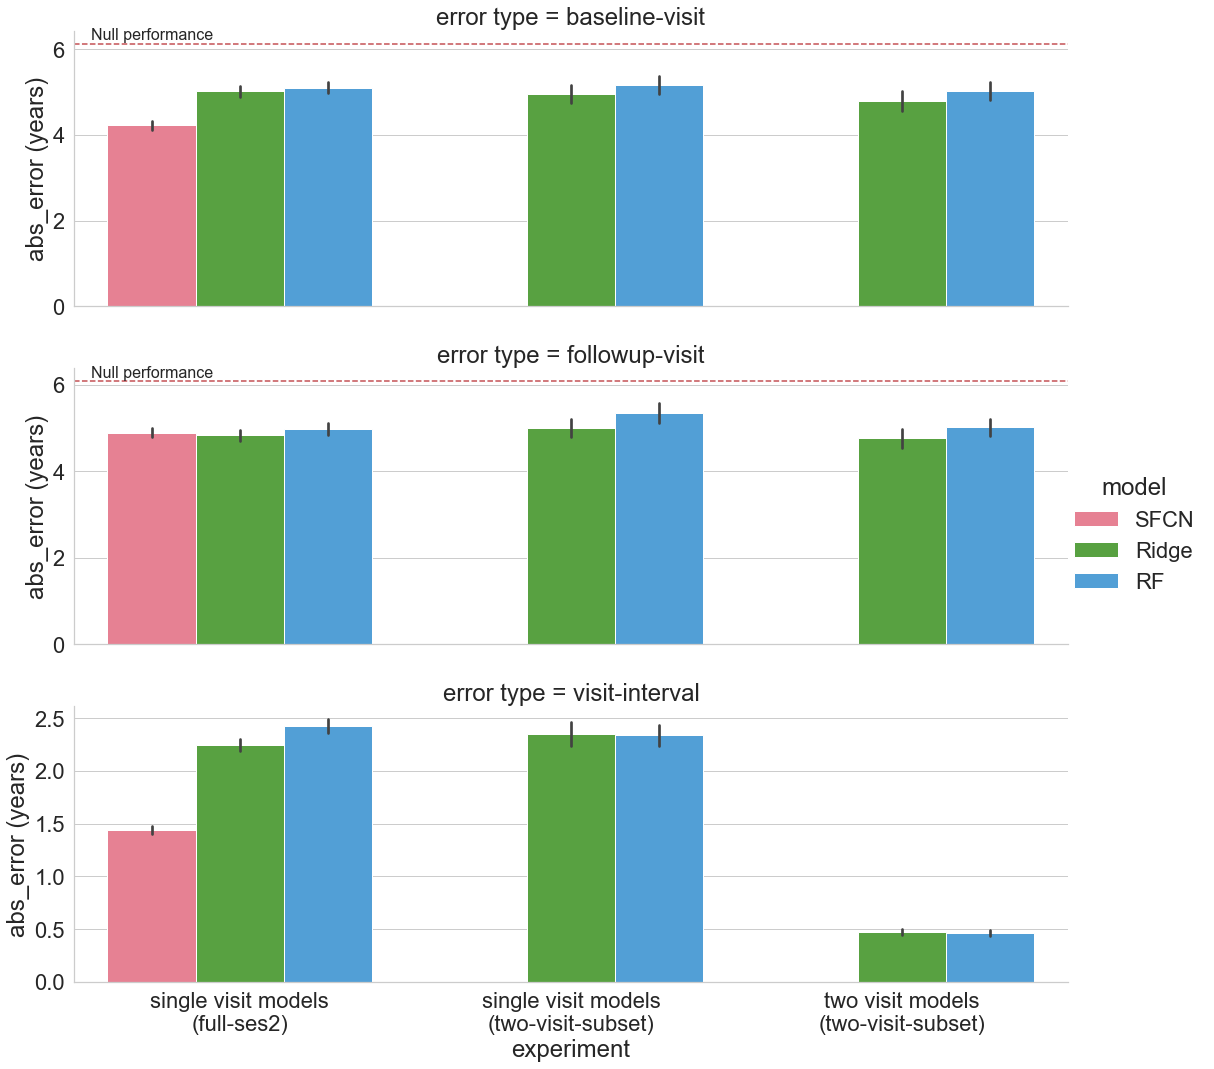

In [5]:
plot_df = perf_df.copy()
plot_df["abs_error (years)"] = np.abs(plot_df["error"]) 
plot_df.loc[plot_df["config"].isin(["SFCN","Baseline_single_visit (full-ses2)"]), "experiment"] = "single visit models\n(full-ses2)"
plot_df.loc[plot_df["config"].isin(["Baseline_single_visit (two-visit-subset)"]), "experiment"] = "single visit models\n(two-visit-subset)"
plot_df.loc[plot_df["config"].isin(["LSN", "Baseline_two_visits"]) & (plot_df["data_aug"]==False), "experiment"] = "two visit models\n(two-visit-subset)"
plot_df.loc[(plot_df["config"].isin(["LSN", "Baseline_two_visits"])) & (plot_df["data_aug"]), "experiment"] = "two visit models with data aug"

# data aug has large delta-brainage error
plot_df = plot_df[plot_df["experiment"].isin(["single visit models\n(full-ses2)","single visit models\n(two-visit-subset)",
                                              "two visit models\n(two-visit-subset)"])]
plot_df = plot_df[plot_df["model"].isin(["RF","Ridge","SFCN"])]
print(plot_df.groupby(["err_type","experiment","model"]).mean()["abs_error (years)"])

#TODO
# rename labels
plot_df["error type"] = plot_df["err_type"].replace({"baseline_err":"baseline-visit","followup_err":"followup-visit", "delta_err":"visit-interval"})

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="experiment",y="abs_error (years)", hue="model", col="error type", col_wrap=1, 
                    kind="bar", data=plot_df, aspect=3, palette="husl", sharey=False)

    ax1, ax2, ax3 = g.axes

    ax1.axhline(null_perf_ses2, ls='--', color="r")
    ax1.text(-0.45,0.1+null_perf_ses2, "Null performance", fontsize=16)

    ax2.axhline(null_perf_ses3, ls='--', color="r")
    ax2.text(-0.45,0.1+null_perf_ses3, "Null performance", fontsize=16)

    # ax3.axhline(null_perf_delta, ls='--', color="r")
    # ax3.text(0,null_perf_delta, "Null performance", fontsize=16)
    

In [7]:
BB_df = perf_df[perf_df["err_type"]=="delta_err"].groupby(["config","model","data_aug"]).sum()["Benjamin_Button"].reset_index()
BB_df["count"] = perf_df[perf_df["err_type"]=="delta_err"].groupby(["config","model","data_aug"]).count()["Benjamin_Button"].values
BB_df["Benjamin Buttons (%)"] = 100*BB_df["Benjamin_Button"] / BB_df["count"]
BB_df[BB_df["data_aug"]==False]

,config,model,data_aug,Benjamin_Button,count,Benjamin Buttons (%)
0,Baseline_single_visit (full-ses2),GB,False,1328,3201,41.487035
1,Baseline_single_visit (full-ses2),RF,False,1160,2867,40.460412
2,Baseline_single_visit (full-ses2),Ridge,False,1065,2867,37.146843
3,Baseline_single_visit (two-visit-subset),GB,False,443,1057,41.911069
4,Baseline_single_visit (two-visit-subset),RF,False,386,958,40.292276
5,Baseline_single_visit (two-visit-subset),Ridge,False,377,958,39.352818
6,Baseline_two_visits,RF,False,0,958,0.000000
8,Baseline_two_visits,Ridge,False,0,958,0.000000
10,LSN,LSN,False,0,958,0.000000
12,SFCN,SFCN,False,363,2933,12.376406


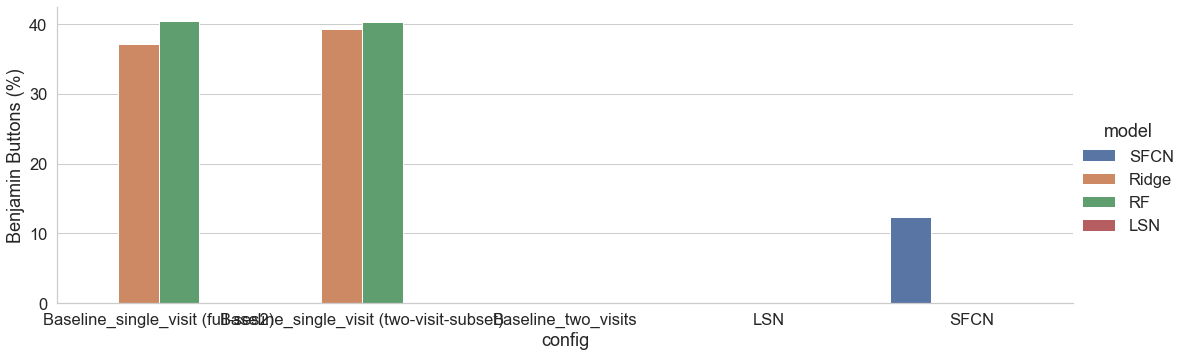

In [9]:
plot_df = BB_df[BB_df["data_aug"]==False].copy()
xorder = ["SFCN","Ridge","RF","LSN"]
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="config",y="Benjamin Buttons (%)", hue="model", hue_order=xorder, kind="bar", data=plot_df,aspect=3)

In [10]:
perf_df.head()

,Unnamed: 0,eid,model,age_at_ses2,brainage_at_ses2,age_at_ses3,brainage_at_ses3,chronoage_delta,brainage_delta,err_type,error,config,data_aug,visit_order,Benjamin_Button
0,0,1004084,SFCN,70.0,66.834612,72.0,68.104931,2.0,1.270319,baseline_err,-3.165388,SFCN,False,NaN,False
1,1,1010063,SFCN,53.0,52.458433,55.0,53.228092,2.0,0.769659,baseline_err,-0.541567,SFCN,False,NaN,False
2,2,1014782,SFCN,70.0,61.505157,72.0,66.927790,2.0,5.422634,baseline_err,-8.494843,SFCN,False,NaN,False
3,3,1016215,SFCN,65.0,65.544100,67.0,68.055118,2.0,2.511018,baseline_err,0.544100,SFCN,False,NaN,False
4,4,1022531,SFCN,66.0,65.136880,68.0,68.032131,2.0,2.895252,baseline_err,-0.863120,SFCN,False,NaN,False


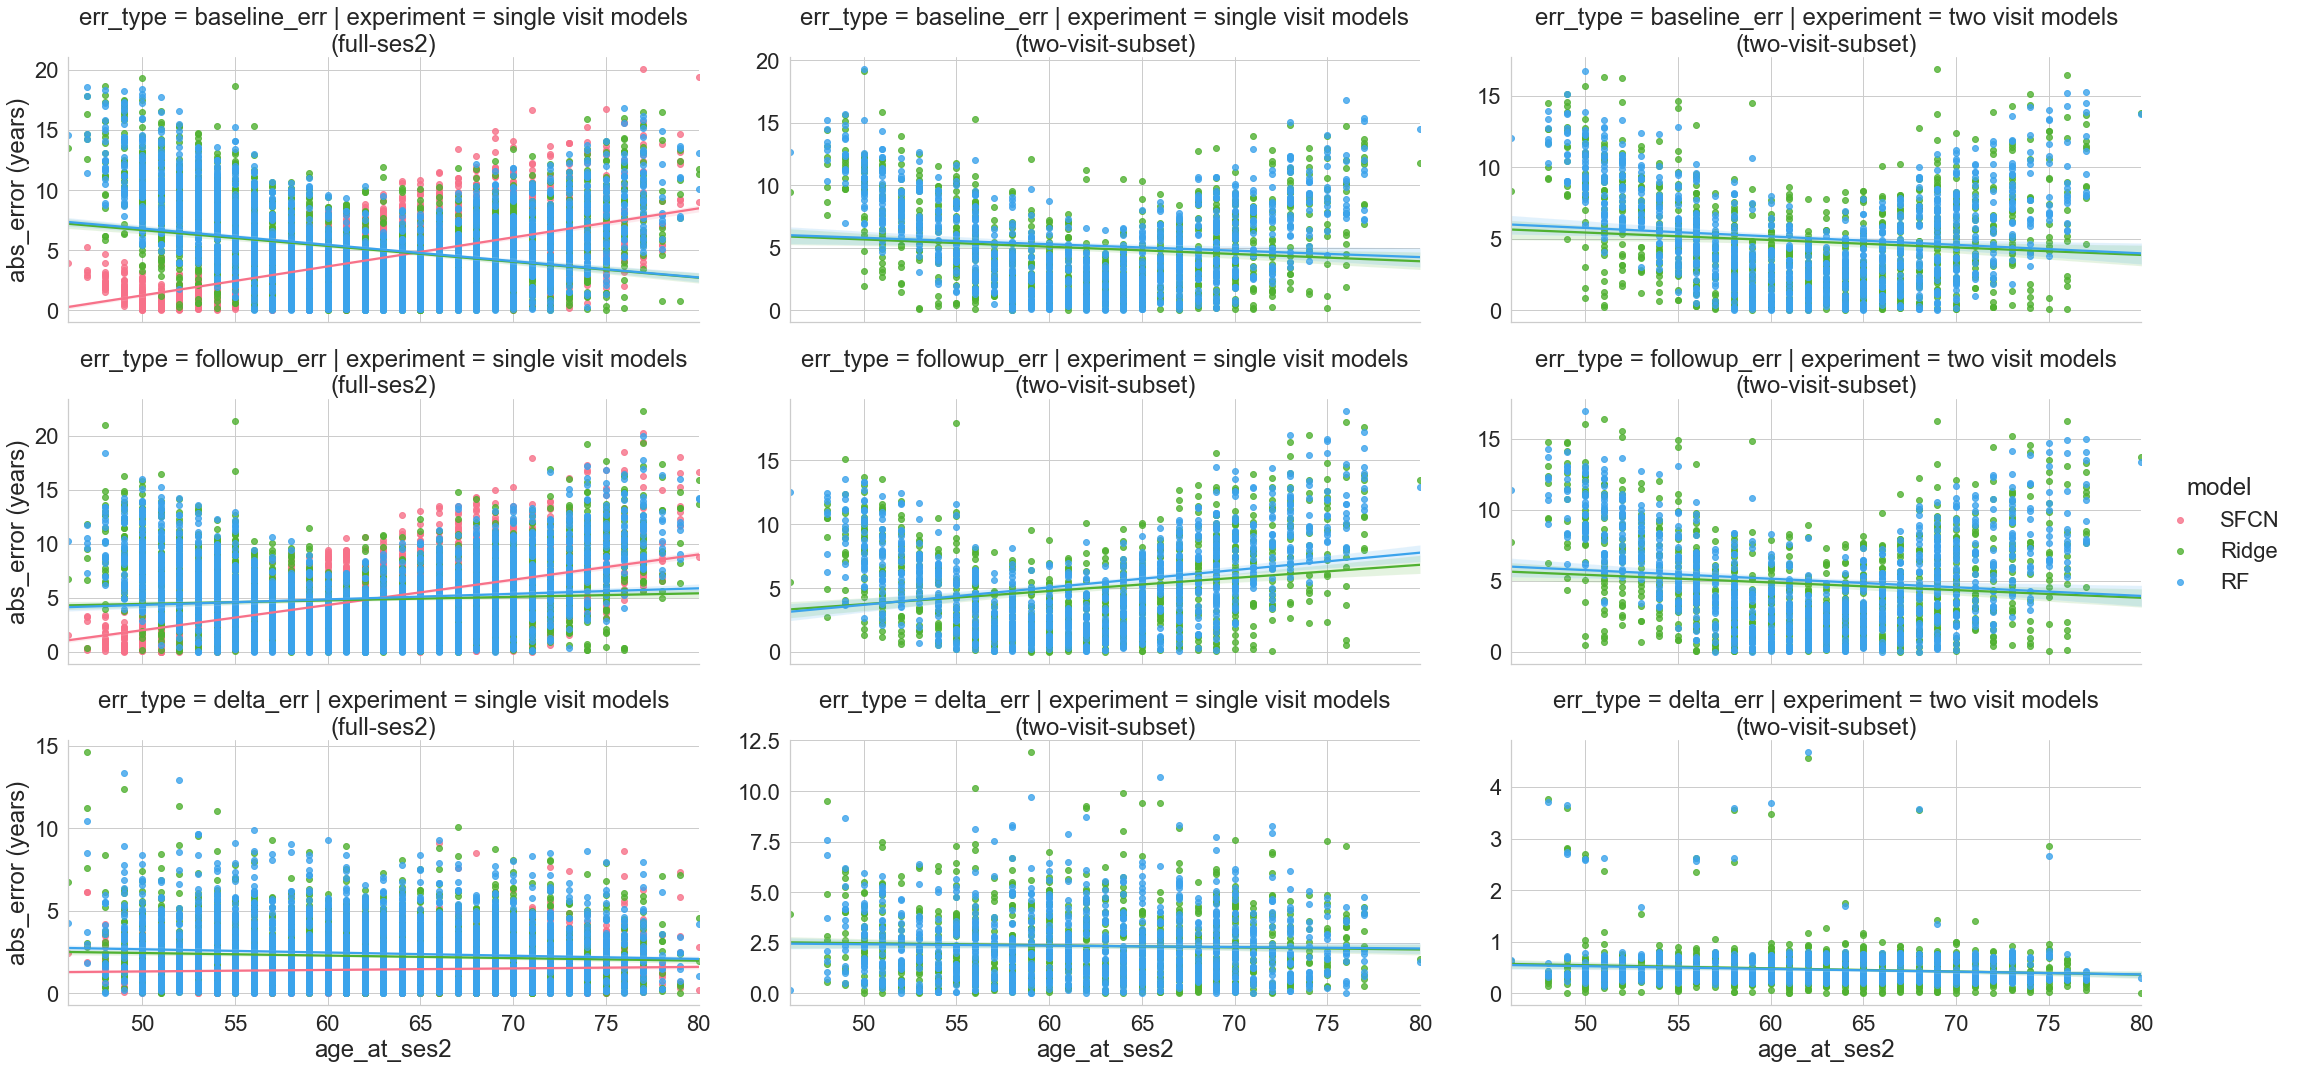

In [30]:
plot_df = perf_df.copy()
plot_df["abs_error (years)"] = np.abs(plot_df["error"]) 
plot_df.loc[plot_df["config"].isin(["SFCN","Baseline_single_visit (full-ses2)"]), "experiment"] = "single visit models\n(full-ses2)"
plot_df.loc[plot_df["config"].isin(["Baseline_single_visit (two-visit-subset)"]), "experiment"] = "single visit models\n(two-visit-subset)"
plot_df.loc[plot_df["config"].isin(["LSN", "Baseline_two_visits"]) & (plot_df["data_aug"]==False), "experiment"] = "two visit models\n(two-visit-subset)"
plot_df.loc[(plot_df["config"].isin(["LSN", "Baseline_two_visits"])) & (plot_df["data_aug"]), "experiment"] = "two visit models with data aug"

# data aug has large delta-brainage error
plot_df = plot_df[plot_df["experiment"].isin(["single visit models\n(full-ses2)","single visit models\n(two-visit-subset)",
                                              "two visit models\n(two-visit-subset)"])]
plot_df = plot_df[plot_df["model"].isin(["RF","Ridge","SFCN"])]

# plot_df = plot_df[(plot_df["err_type"]=="baseline_err") & (plot_df["experiment"].isin(["single visit models\n(full-ses2)"]))]
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.lmplot(x="age_at_ses2",y="error", hue="model", col="experiment",row="err_type",
                    data=plot_df, palette="husl",sharey=False, aspect=2)

In [5]:

# subject_dir = "/home/nikhil/projects/brain_changes/data/adni/imaging/fmriprep/sub-ADNI941S5193/"
# img_subdir = "ses-bl/anat/"
# T1_filename = "sub-ADNI941S5193_ses-bl_space-MNI152Lin_res-1_desc-preproc_T1w.nii.gz"
# brainmask_filename = "sub-ADNI941S5193_ses-bl_space-MNI152Lin_res-1_desc-brain_mask.nii.gz"
# masked_T1_filename = "sub-ADNI941S5193_ses-bl_space-MNI152Lin_res-1_desc-preproc-masked_T1w.nii.gz"

# T1_mni = f"{subject_dir}{img_subdir}{T1_filename}"
# T1 = nib.load(T1_mni)
# T1_data = T1.get_fdata()

# # Apply brain mask
# brainmask_mni = f"{subject_dir}{img_subdir}{brainmask_filename}"
# brainmask_data = nib.load(brainmask_mni).get_fdata()

# masked_T1_data = brainmask_data * T1_data
# masked_T1 = nib.Nifti1Image(masked_T1_data, header=T1.header, affine=T1.affine)

# nib.save(masked_T1, f"{subject_dir}{img_subdir}{masked_T1_filename}")    